In [26]:
from os import listdir
from os.path import isfile, join, basename
from pathlib import Path
from tabulate import tabulate


# Create a dictionary of data files
data_path  = 'data/'
data_lake  = { Path(f).stem : join(data_path,f) for f in listdir(data_path) if isfile(join(data_path,f)) }
data_table = [[str(i), k] for i, k in enumerate(data_lake)]
data_table = tabulate(data_table, headers=['id', 'Data Sets'])

header = "Available datasets in folder 'data'"
print(header)
print(len(header)*'=','\n')
print(data_table)

# data_set_id = input('Select a dataset (id):')
# data_set_loc = data_files[int(data_set_id)]

Available datasets in folder 'data'

  id  Data Sets
----  -----------
   0  djia


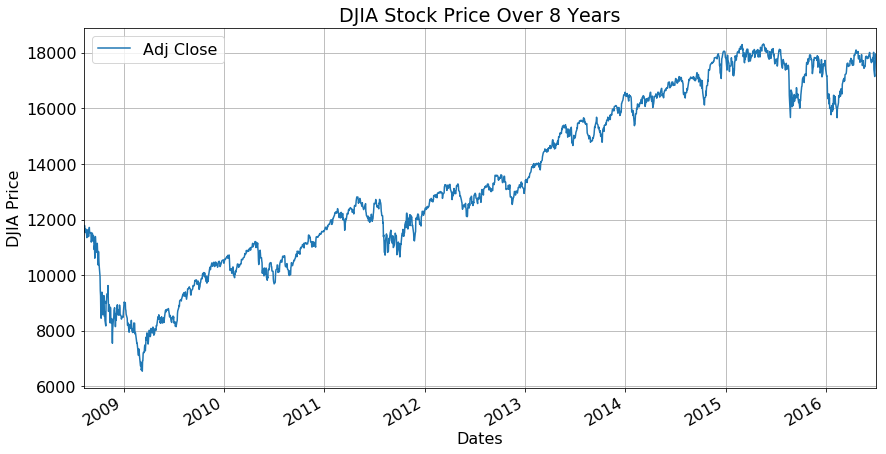

In [27]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
%matplotlib inline

# Reads in data and checks to see none of the data is null
df = pd.read_csv(data_lake['djia'])
assert(df.isnull().sum().sum() == 0)

# Processes file so that data is indexed by date
df = df.sort_values(by='Date')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display code for moving averages
# ma_list = [10, 20, 50, 100, 200]
# boxes   = [widgets.Checkbox(value=False,description=str(i)+' Day MA', disabled=False) for i in ma_list]
# ma_dict = {str(ma_list[i]) : (boxes[i], None) for i in range(len(boxes))}

# def box_value_change(change):
#     window = re.search('\d*', change['owner'].description).group()
    
#     if change.new == True:
#         ma_dict[window] = ax.plot(
#             df['Adj Close'].rolling(window).mean(), label=window + 'Day MA')
#     else:
#         del boxes[window][1]
#     plt.show()

# for k, (box, _) in ma_dict.items():
#     box.observe(box_value_change, names='value')
#     display(box)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11,5))
ax = fig.add_axes([0,0,1,1])
df.plot(y='Adj Close',ax=ax)
# ax.plot(df['Adj Close'].rolling(100).mean(), label='10 Day MA')


ax.set_xlabel('Dates')
ax.set_ylabel('DJIA Price')
ax.set_title('DJIA Stock Price Over 8 Years')
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

# boxes   = { str(ma_list[i]) : 
#            [,
#             None] for i in enumerate(ma_list) }
 
# print(boxes)
# for k, v in boxes.items():
    
#     # 
#     display(v[0])

In [28]:
# If high frequency signal is greater than lower frequency signal -> True
# With the equalitiy, we are also able to use it for modeling classical
# buy and hold strategy
buyIndicator  = lambda hf,lf: ~np.isnan(hf) and ~np.isnan(lf) and hf >= lf

def crossoverProfit(price, lf, hf=None, starting_cash=10000, indicator=lambda x,y: x > y, verbose=False):
    """
    Calculates the profit from crossover of the given low freq and high freq signals
    
    Inputs:
    hf        - higher frequency signal: price, 10 day mva etc.
    lf        - lower frequency signal: 50/200 day mva etc.
    indicator - function determining when hf is greater than lf
    
    Returns the profit made.
    """
    
    # Use the price if another average is not given
    if hf is None:
        hf = price
    
    assert lf.shape == hf.shape
    
    # Calculate crossover
    result     = np.array([indicator(hf[i], lf[i]) for i in range(len(lf))])
    result[1:] = np.not_equal(result[1:], result[0:-1])
    crossover  = result.astype(np.bool)
    
    # Extract time index of crossover
    crossover = np.array([time for time, signal in np.ndenumerate(crossover) if signal == True])
    
    cash = starting_cash
    for i, time in enumerate(crossover):
        if i % 2 == 0:
            num_stocks = cash / price[time]
        else:
            cash = num_stocks * price[time]
            
    # Make sure at end of time series to sell if currently holding stocks           
    if len(crossover) % 2 == 1:
        cash = num_stocks * price[-1]
        
    profit = cash - starting_cash
    
    if verbose:
        print(f'Initial value : $ {starting_cash:.2f}')
        print(f'Final value   : $ {cash.item():.2f}')
        print(f'Profit        : $ {profit.item():.2f}')
            
    return profit

In [29]:
def evaluateCrossoverStrategy(price, windows, indicator, starting_cash=10000):
    """
    Inputs:
    price        - as a single pandas data frame
    window_sizes - window lengths to use as moving averages
    indicator    - input passed to crossoverProfit (see documentation)
    
    Returns a matrix of the crossover profit generated with different moving average windows
    """
    
    profit_matrix = np.zeros((windows.size, windows.size))

    for i in range(windows.size):
        for j in range(windows.size):

            if (windows[i] == 1 and windows[j] == 1) or windows[j] > windows[i]:
                hf = price.rolling(windows[i]).mean().to_numpy()
                lf = price.rolling(windows[j]).mean().to_numpy()
                profit_matrix[i,j] = crossoverProfit(price=price.to_numpy(), 
                                                     lf=lf, hf=hf, 
                                                     starting_cash=starting_cash,
                                                     indicator=buyIndicator)
    
    return profit_matrix

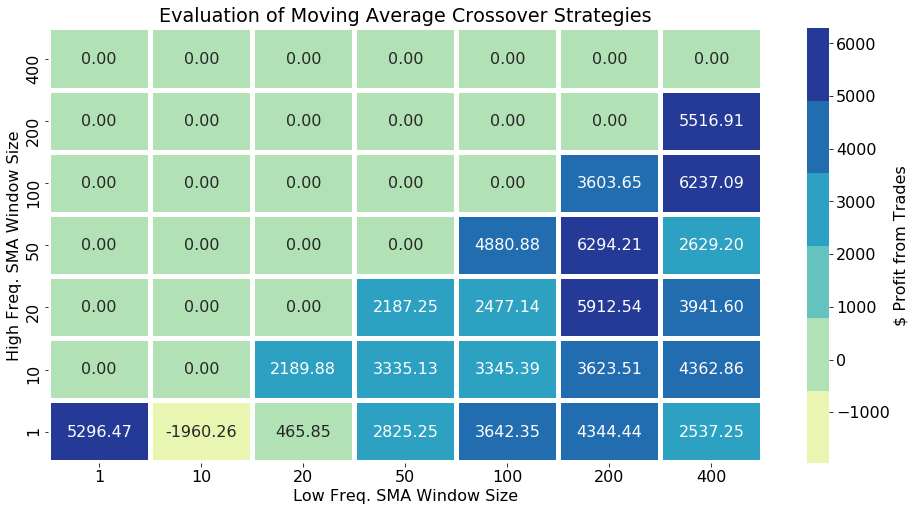

Best Crossover Pair: (50,200)
Buy and Hold Profit: $ 5296.47
Best Pair Profit   : $ 6294.21


In [30]:
# Visualize a heatmap of all the different crossover strategies
import seaborn as sns

window_sizes = np.array([1, 10, 20, 50, 100, 200, 400])



profit = evaluateCrossoverStrategy(
    df['Adj Close'], 
    windows=window_sizes, 
    indicator=buyIndicator,
    starting_cash=10000)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.rcParams['font.size'] = 16
ax = sns.heatmap(profit, annot=True, fmt='.2f', linewidth=4,
            xticklabels=window_sizes,
            yticklabels=window_sizes,
            cbar_kws={'label': '$ Profit from Trades'},
            cmap=sns.color_palette("YlGnBu"));
ax.invert_yaxis()
ax.set_xlabel('Low Freq. SMA Window Size')
ax.set_ylabel('High Freq. SMA Window Size')
ax.set_title('Evaluation of Moving Average Crossover Strategies')
plt.show()

best_pair  = np.unravel_index(profit.argmax(), profit.shape)
max_profit = profit[best_pair]

best_pair_str = f'({window_sizes[best_pair[0]]},{window_sizes[best_pair[1]]})'
print(f'Best Crossover Pair: {best_pair_str}')
print(f'Buy and Hold Profit: $ {profit[0,0]:.2f}')
print(f'Best Pair Profit   : $ {max_profit:.2f}')

The above plot shows the evaluation of various crossover strategies based on the simple moving average. This code can be used to select the best low frequency and high frequency moving average indicators for comparison with our model. The number in the (1,1) coordinate actually reflects the profit of a simple buy once and hold strategy (moving average window for both signals is simply the price itself). For the DJIA stock price, the best moving average pair to use is the 50 day MA as the short term indicator and the 200 day MA as the long term indicator.

# Random Forest Classifier Analysis

## Caclulating Technical Indicators

In [105]:
import warnings

indicators = {}
params = {}

def plotIndicator(val, title, x=None):
    plt.rcParams['font.size'] = 16
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])
    
    # If datetime information supplied
    if x is not None:
        plt.plot(x, val)
    else:
        plt.plot(val)
    ax.set_title(title)
    ax.set_xlabel('Dates')
    fig.autofmt_xdate(rotation=30)
    ax.grid()
    plt.show()
    
# Sanity check utility function
def verifyTrend(v):
    """
    Numpy vector should only contain 1's, -1's and nan's
    """
    plusones = (v == 1).sum()
    minusones = (v == -1).sum()
    nans = (np.isnan(v)).sum()
    assert(v.size == (plusones + minusones + nans))
    
price = df['Adj Close']
dates = df['Adj Close'].index

### Simple Moving Average

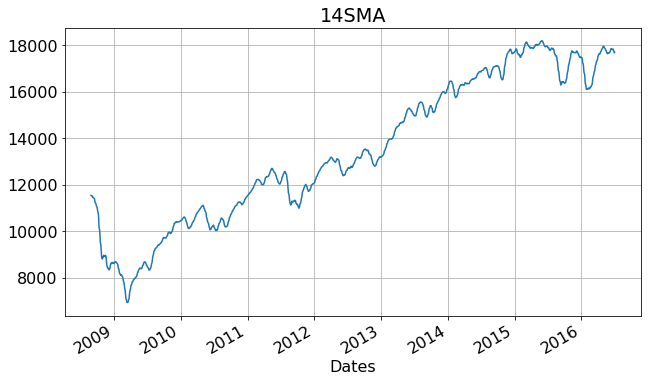

In [106]:
# As in paper calculate 14 day sample moving average
params['sma.window'] = 14
key = str(params['sma.window'])+'SMA'

indicators[key] = price.rolling(params['sma.window']).mean().to_numpy()
plotIndicator(indicators[key], key, x=dates)

# Finally convert into an +1/-1 value
indicators[key][price >= indicators[key]] = 1
indicators[key][price < indicators[key]] = -1

### Weighted Moving Average

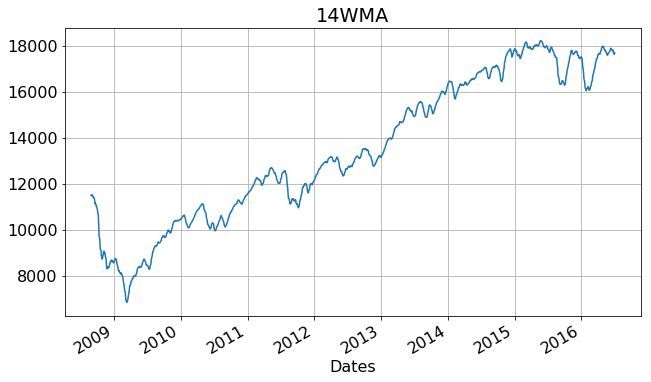

In [107]:
# As defined in paper calculate 10 day weighted moving average
params['wma.window'] = 14
key = str(params['wma.window'])+'WMA'

w   = np.arange(1,params['wma.window']+1) 
wma = lambda x: ((w*x) / w.sum()).sum()

indicators[key] = price.rolling(params['wma.window']).apply(wma, raw=True).to_numpy()
plotIndicator(indicators[key], key, x=dates)

# Finally convert into an +1/-1 value
indicators[key][price >= indicators[key]] = 1
indicators[key][price < indicators[key]] = -1

### Momentum

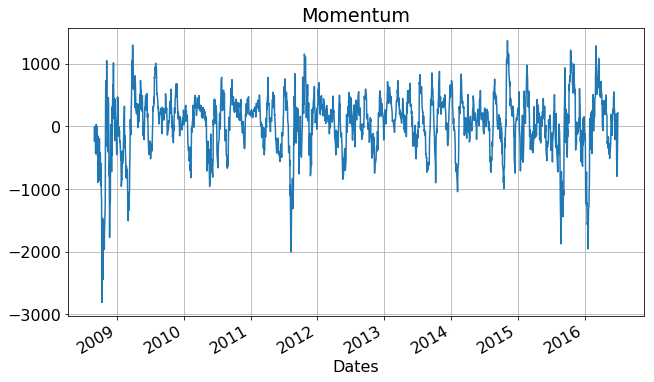

In [108]:
params['momentum.window'] = 14
key = 'Momentum'

momentum = np.full(price.shape, np.nan)
ahead    = price[params['momentum.window']:].to_numpy()
behind   = price[:-params['momentum.window']].to_numpy()
momentum[params['momentum.window']:] =  ahead - behind
indicators[key] = momentum

plotIndicator(indicators[key], key, x=dates)

# Finally convert into an +1/-1 value
with warnings.catch_warnings():
    # Comparison with nan values creates warnings
    warnings.filterwarnings('ignore', 'invalid')
    indicators[key][indicators[key] >= 0] = 1
    indicators[key][indicators[key] < 0] = -1

### Relative Strength Indicator

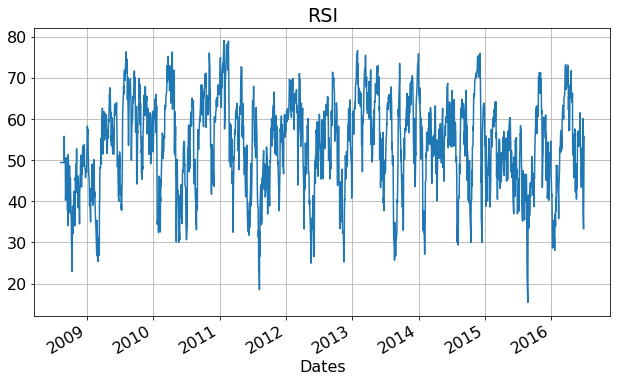

In [109]:
# Reference: https://github.com/mtamer/python-rsi/blob/master/Stock%20Screener/rsi.py
params['rsi.window'] = 14
params['rsi.overbought'] = 70
params['rsi.oversold'] = 30
key = 'RSI'

def RSI(prices, n=14):
    deltas = np.diff(prices)
    seed   = deltas[:n]
    
    up   = seed[seed>=0].sum() / (n)
    down = -seed[seed<0].sum() / (n)
    rs   = up / down
    rsi  = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)
    
    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up     = (up*(n-1) + upval) / n
        down   = (down*(n-1) + downval) / n
        rs     = up / down
        rsi[i] = 100. - 100./(1.+rs)
        
    return rsi

indicators[key] = RSI(price.to_numpy(), n=params['rsi.window'])
plotIndicator(indicators[key], key, x=dates)

# Finally convert into an +1/-1 value
v = np.full(indicators[key].shape, np.nan)
v[indicators[key] > params['rsi.overbought']] = -1
v[indicators[key] < params['rsi.oversold']] = 1

# When RSI value is between oversold and overbought parameters
middle = np.logical_and(indicators[key] >= params['rsi.oversold'], 
                        indicators[key] <= params['rsi.overbought'])
rsi_diff = np.diff(indicators[key])

# Fills in labels +1/-1 when in between RSI parameters
upTrend = np.logical_and(middle[params['rsi.window']:], rsi_diff[params['rsi.window']-1:] >=0)
downTrend = np.logical_and(middle[params['rsi.window']:], rsi_diff[params['rsi.window']-1:] < 0)
v[params['rsi.window']:][upTrend] = 1
v[params['rsi.window']:][downTrend] = -1
verifyTrend(v)
indicators[key] = v

### Stochastics %K and %D

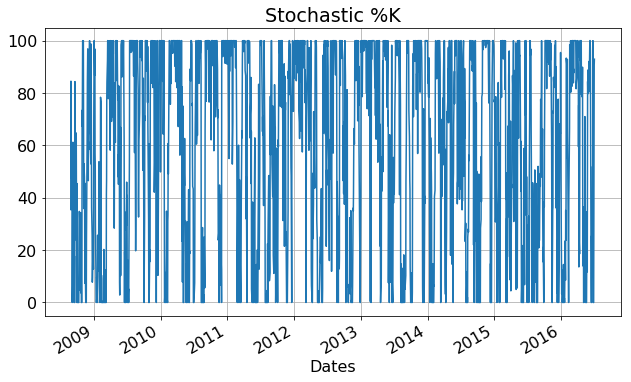

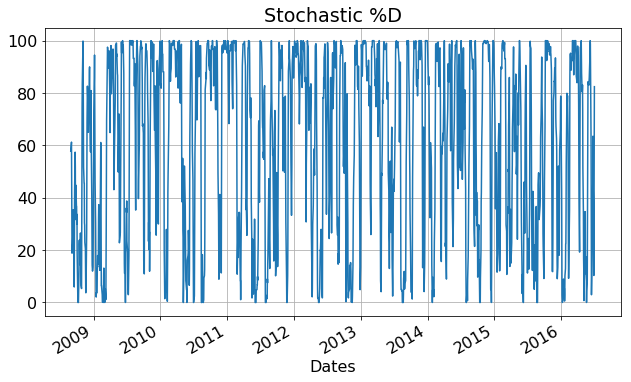

In [110]:
# As desribed in this page: https://www.investopedia.com/articles/technical/073001.asp
params['stochastic.window'] = 14
keys = ['Stochastic %K', 'Stochastic %D']

def stochastics(price, n=14):
    
    k = np.full(price.shape, np.nan)
    for i in range(0, len(price)-n+1):
        cp = price[i+n-1] # closing price
        ll = np.min(price[i:i+n]) # lowest low
        hh = np.max(price[i:i+n]) # highest high
        k[i+n-1] = 100 * (cp - ll) / (hh - ll)

    # For %D it is a 3 day SMA of %K 
    # (e.g. first 13:16 [15-2:15+1])
    d = np.full(price.shape, np.nan)
    for i in range(n+1,len(price)):
        d[i] = k[i-2:i+1].mean()

    return (k, d)
    
result = stochastics(price.to_numpy(), n=params['stochastic.window'])
indicators['Stochastic %K'], indicators['Stochastic %D'] = result

# Finally plot and convert into an +1/-1 value
for key in keys:
    plotIndicator(indicators[key], key, x=dates)
    
    with warnings.catch_warnings():
        # Comparison with nan values creates warnings
        warnings.filterwarnings('ignore', 'invalid')
        diff = np.diff(indicators[key])
        v = np.full(indicators[key].shape, np.nan)
        v[1:][np.logical_and(~np.isnan(diff),diff >= 0)] = 1
        v[1:][np.logical_and(~np.isnan(diff),diff < 0)] = -1
        verifyTrend(v)
        indicators[key] = v

### Larry Williams R%

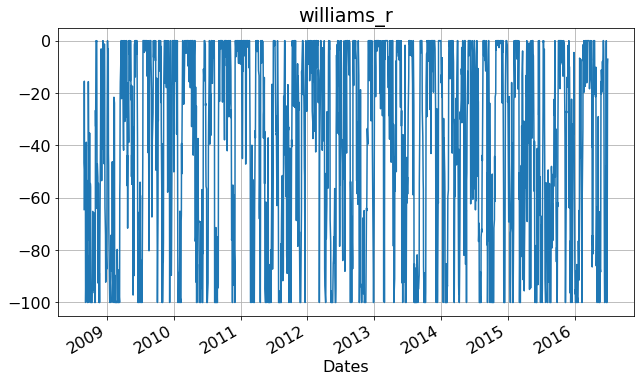

In [111]:
params['williams_r.window'] = 14
key = 'williams_r'

def williams_range(price, n=14):
    
    f = lambda x: -100 * (x.max()-x[-1])/(x.max()-x.min())
    oscillator = price.rolling(n).apply(f, raw=True).to_numpy()
    return oscillator

indicators[key] = williams_range(price, params['williams_r.window'])
plotIndicator(indicators[key], key, x=dates)

v = np.full(indicators[key].shape, np.nan)
diff = np.diff(indicators[key])
with warnings.catch_warnings():
    # Comparison with nan values creates warnings
    warnings.filterwarnings('ignore', 'invalid')
    v[1:][np.logical_and(~np.isnan(diff),diff >= 0)] = 1
    v[1:][np.logical_and(~np.isnan(diff),diff < 0)] = -1

verifyTrend(v)
indicators[key] = v

### Moving Average Convergence Divergence

### Additional Indicators To Implement
- Moving Average Convergence Divergence
- Accumulation/Distribution Oscillator
- Commodity Channel Index

## Define Label

In [170]:
# Days to predict ahead
predict_ahead = 14
labels_raw = np.full(price.shape, np.nan)
for i in range(0, len(price)-predict_ahead):
    labels_raw[i] = price[i+predict_ahead] - price[i]

with warnings.catch_warnings():
    # Comparison with nan values creates warnings
    warnings.filterwarnings('ignore', 'invalid')
    labels_raw[labels_raw >= 0] = 1
    labels_raw[labels_raw < 0] = -1

## Assemble Train/Test Data

In [171]:
features_raw = np.hstack([value[:, None] for _, value in indicators.items()])

# Remove rows with nans
rowsbool = np.isnan(features_raw).any(axis=1)
rowsbool = np.logical_or(rowsbool, np.isnan(labels_raw))
rows     = np.arange(features_raw.shape[0])[rowsbool]
print(f'Removing the following times')
print(f'============================')
for row, time in zip(rows, dates[rows].format(formatter=lambda x: x.strftime('%Y/%m/%d'))):
    print(f'row: {row:>4}   time: {time}')
features = features_raw[~rowsbool,:]
labels   = labels_raw[~rowsbool]
feature_list = [key for key, _ in indicators.items()]

Removing the following times
row:    0   time: 2008/08/08
row:    1   time: 2008/08/11
row:    2   time: 2008/08/12
row:    3   time: 2008/08/13
row:    4   time: 2008/08/14
row:    5   time: 2008/08/15
row:    6   time: 2008/08/18
row:    7   time: 2008/08/19
row:    8   time: 2008/08/20
row:    9   time: 2008/08/21
row:   10   time: 2008/08/22
row:   11   time: 2008/08/25
row:   12   time: 2008/08/26
row:   13   time: 2008/08/27
row:   14   time: 2008/08/28
row:   15   time: 2008/08/29
row: 1975   time: 2016/06/14
row: 1976   time: 2016/06/15
row: 1977   time: 2016/06/16
row: 1978   time: 2016/06/17
row: 1979   time: 2016/06/20
row: 1980   time: 2016/06/21
row: 1981   time: 2016/06/22
row: 1982   time: 2016/06/23
row: 1983   time: 2016/06/24
row: 1984   time: 2016/06/27
row: 1985   time: 2016/06/28
row: 1986   time: 2016/06/29
row: 1987   time: 2016/06/30
row: 1988   time: 2016/07/01


In [172]:
from sklearn.model_selection import train_test_split

seed = 20

features = features[:]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=seed)

print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

# assert(len(indicators) == x_train.shape[1])

Training Features Shape: (1469, 7)
Training Labels Shape: (1469,)
Testing Features Shape: (490, 7)
Testing Labels Shape: (490,)


### Establish Baseline

In [173]:
baseline_preds = np.ones_like(y_test)

def modelAccuracy(preds, truth):
    n = np.equal(preds, truth).sum()
    return 100 * n / truth.size

accuracy = modelAccuracy(baseline_preds, y_test)
print(f'Average Baseline Accuracy: {round(accuracy, 2)}%')

Average Baseline Accuracy: 60.0%


Since the data is mostly of a bull market (except year 2009), let the default prediction be that the market trends up by default. The error shows that the market goes up and down an equal amount of times but the magnitude of the changes is what actually drives the market up.

## Train Random Forest Classifer

In [174]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def evaluateRandomForest(x_train, y_train, x_test, y_test, forest_sizes, max_features):

    accuracyMat = np.zeros((max_features.size, len(forest_sizes)))
    for i, num_features in enumerate(max_features):
        for j, num_trees in enumerate(forest_sizes):

            rf = RandomForestClassifier(n_estimators=num_trees, 
                                       random_state=seed, 
                                       max_features=num_features)
            # Train the model on training data
            rf.fit(x_train, y_train)

            predictions = rf.predict(x_test)
            accuracyMat[i,j] = modelAccuracy(predictions, y_test)
            
    return accuracyMat

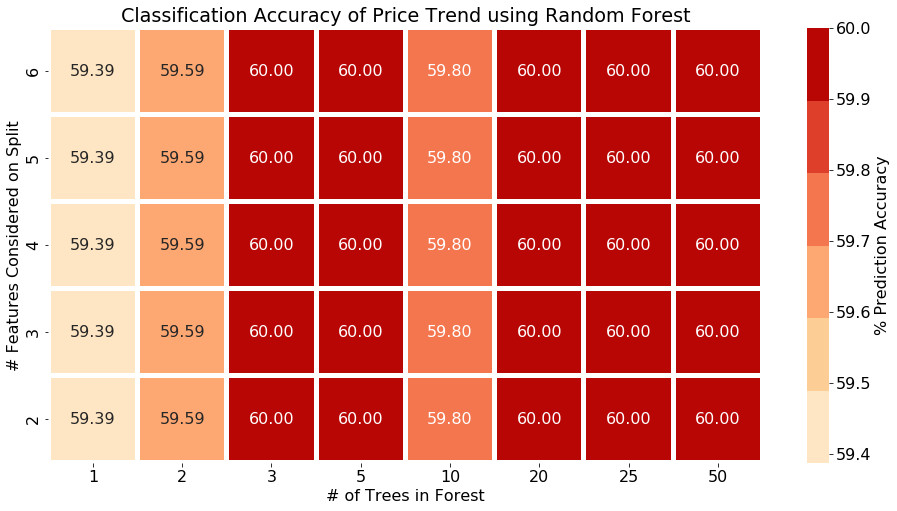

Best Model Accuracy: % 60.00
Best Random Forest Model Hyperparameters
# Features considered on split: 2
# Trees in Forest: 3


In [175]:
forest_sizes = [1, 2, 3, 5, 10, 20, 25, 50]
max_features = np.arange(2, x_train.shape[1])
prediction_accuracy = evaluateRandomForest(x_train, y_train, x_test, y_test, forest_sizes, max_features)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.rcParams['font.size'] = 16
ax = sns.heatmap(prediction_accuracy, annot=True, fmt='.2f', linewidth=4,
            xticklabels=forest_sizes,
            yticklabels=max_features,
            cbar_kws={'label': '% Prediction Accuracy'},
            cmap=sns.color_palette("OrRd"));
ax.invert_yaxis()
ax.set_xlabel('# of Trees in Forest')
ax.set_ylabel('# Features Considered on Split')
ax.set_title('Classification Accuracy of Price Trend using Random Forest')
plt.show()

# Summary of best model
best_pair     = np.unravel_index(prediction_accuracy.argmax(), prediction_accuracy.shape)
best_accuracy = prediction_accuracy[best_pair]

print(f'Best Model Accuracy: % {best_accuracy:.2f}')
title = 'Best Random Forest Model Hyperparameters'
print(title)
print(len(title)*'=')
print(f'# Features considered on split: {max_features[best_pair[0]]}')
print(f'# Trees in Forest: {forest_sizes[best_pair[1]]}')

### Feature Importance Analysis

In [169]:
# Rebuild tree with best performance prediction and analyze feature importance
rf = RandomForestClassifier(n_estimators=forest_sizes[best_pair[1]], 
                           random_state=seed, 
                           max_features=max_features[best_pair[0]])

# Train the model on training data
rf.fit(x_train, y_train)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print(f'Variable: {pair[0]:20} Importance: {pair[1]:.2f}') for pair in feature_importances];

Variable: 14WMA                Importance: 0.37
Variable: 14SMA                Importance: 0.19
Variable: Stochastic %D        Importance: 0.13
Variable: Stochastic %K        Importance: 0.11
Variable: RSI                  Importance: 0.09
Variable: williams_r           Importance: 0.05
Variable: Momentum             Importance: 0.04
